# Unit 1 - Modelling and Representations of Systems
# Part 4 - Frequency Domain

- Modelling of electrical and mechanical systems
    - Electric circuits with resistors, capacitors, inductors, op-amps
    - Translational mechanical systems
    - Rotational mechanical systems
- Representations
    - Frequency domain
- Key Concept
    - Poles
    - Zeros
- Plots
    - Bode

![Fourier](Fourier.jpg "Fourier")
source: https://en.wikipedia.org/wiki/Joseph_Fourier
- March 21 1768 - May 16 1830
- Fourier accompanied Napoleon Bonaparte on his Egyptian expedition in 1798, as scientific adviser
- Known for initiating the investigation of Fourier series
- Applications to problems of heat transfer and vibrations


![Bode](Hendrik_Wade_Bode.png "Bode")
source: https://en.wikipedia.org/wiki/Hendrik_Wade_Bode
- December 24 1905 - June 21 2982
- pioneer of modern control theory and electronic telecommunications 
- His synergy with Claude Shannon, the father of information theory, laid the foundations for the technological convergence of the information age
- Contributions to the design, guidance and control of anti-aircraft systems during World War II
- During the Cold War, he contributed to the design and control of missiles and anti-ballistic missiles



# What is frequency domain?

Based on two facts:
- every signal can be expressed as a weighted sum of sinusoids of different frequencies,
- for a sinusoidal input, the output of a LTI system is a sinusoid at the same frequency, but with different magnitude and phase.

Poles of system: [-0.5+1.32287566j -0.5-1.32287566j]


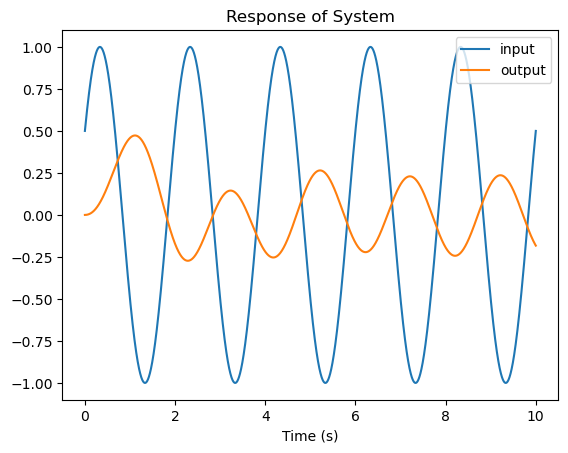

In [1]:
import math
import numpy as np
import control as ct
import matplotlib.pyplot as plt

den_sys = np.array([1, 1, 2])
num_sys = np.array([2])

print('Poles of system:', np.roots(den_sys))

N = 10000
dt = 1/1000
t = np.linspace(0,dt*N,N)

f = 1/2   #frequency of sinusoid
theta = math.pi/6
u_sinusoid = np.sin(2*math.pi*f*t + theta)

# simulate the system output for selected input signal (note initial conditions are assumed to be zero)
sys = ct.TransferFunction(num_sys,den_sys)
tout, yout = ct.forced_response(sys,U=u_sinusoid,T=t)

# plot the response
fig, ax = plt.subplots(1,1)
ax.plot(t, u_sinusoid, label='input')
ax.plot(tout, yout, label='output')
ax.set_title('Response of System')
ax.set_xlabel('Time (s)')
plt.legend()

plt.show()

# Transforming between representations

From time domain to frequency domain: Continuous Time Fourier Transform.
$$
\begin{align*}
Y(j \omega) = \int_{\infty}^{\infty} y(t) e^{-j \omega t} dt
\end{align*}
$$

Frequency Domain to time domain: Inverse Continuous Time Fourier Transform
$$
\begin{align*}
y(t) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} Y(j \omega) e^{j \omega t}
\end{align*}
$$

Laplace to Frequency domain:
$$
\begin{align*}
G(j \omega) = G(s) \Big |_{s=j \omega}
\end{align*}
$$

Frequency to Laplace domain:
$$
\begin{align*}
G(s) = G(j \omega) \Big |_{j \omega = s}
\end{align*}
$$

# Bode Plot - Visualizing the Frequency Domain

Bode plot consists of two plots: 
- x-axis of both plots is frequency (usually in radians). Axis is logarithmic.
- y-axis of top plot is called the Magnitude plot.
- y-axis of bottom plot is called Phase plot.

To construct a Bode Plot of $G(s)$:
1. excite the system with a sinusoid of frequency $\omega$ with unit magnitude and known phase
2. determine the magnitude of phase shift of the output sinusoid
3. plot the magnitude of the output on the top plot (a point at frequency $\omega$)
4. plot the phase shift of the output on the bottom plot
5. Return to step one for a new frequency $\omega$.


# In Class Activity!

- Look at the Bode plots of various systems
    - Second order
    - systems with large poles, small zeros, and vice-versa
    - Higher order
    - Low pass
    - High pass
    - Notch filter

From the video's (or previous courses), based on the rules of constructing Bode Plots: 
- How would we construct a Low-Pass System (a system where high frequencies are dampened)?
- How would we construct a High-Pass System (a system where low frequencies are dampened)?

In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import enel441_utilities as eu

def enel441_get_reasonable_freq_range(num, den, N):
    roots_den = np.roots(den)
    den_corner_freqs = np.abs(roots_den)
    
    if num.shape[0]>1:
        roots_num = np.roots(num)   
        num_corner_freqs = np.abs(roots_num)
        omega_min = np.min( [np.min(den_corner_freqs), np.min(num_corner_freqs)] )
        omega_max = np.max( [np.max(den_corner_freqs), np.max(num_corner_freqs)] )
    else:
        omega_min = np.min(den_corner_freqs)
        omega_max = np.max(den_corner_freqs)
        
    omega = np.logspace(np.log10(omega_min/100),np.log10(omega_max*100),num=N)
    return omega


def enel441_fourier_transform(num,den,omega):

    G_jw = np.zeros(N,dtype=np.csingle)
       
    ii = 0
    for w in omega:
        jomega = 1j*w
        num_jw = 0
        jj = num.shape[0] - 1
        for nn in num:
            num_jw += nn*(jomega**jj)
            jj -= 1
        
        den_jw = 0
        jj = den.shape[0] - 1
        for dd in den:
            den_jw += dd*(jomega**jj)
            jj -= 1
        #print(den_jw)
        #print(num_jw)
        G_jw[ii] = num_jw/den_jw
        ii += 1
    return G_jw

def find_nearest(arr, value):
    idx = (np.abs(arr - value)).argmin()
    return idx


def enel441_approximate_bode(num_sys,den_sys,omega):
    N = omega.shape[0]
    
    roots_den = np.roots(den_sys)
    den_corner_freqs = np.abs(roots_den)
    num_poles = roots_den.shape[0]
    
    if num_sys.shape[0]>1:
        roots_num = np.roots(num_sys)
        num_corner_freqs = np.abs(roots_num)
        num_zeros = roots_num.shape[0] 
    else:
        num_zeros = 0
        num_corner_freqs = []
        roots_num = []

    # calculate DC offset
    dc_offset = num_sys[0]/den_sys[0]
    for rr in roots_den:
        dc_offset /= rr

    for rr in roots_num:
        dc_offset *= rr

    dc_offset = 20*np.log10(np.abs(dc_offset))


    pole_approx_mag = np.zeros((N,num_poles))
    pole_approx_phase = np.zeros((N,num_poles))
    slope_neg = -20*np.log10(omega)
    ii = 0
    print(num_poles)
    print(den_corner_freqs)
    for cf in den_corner_freqs:
        corner_idx = find_nearest(omega,cf)
        pole_approx_mag[corner_idx:N,ii] = slope_neg[corner_idx:N] - slope_neg[corner_idx]
        p1 = find_nearest(omega,cf/10)
        p2 = find_nearest(omega,cf*10)
        pole_approx_phase[p1:p2,ii] = -np.linspace(0,math.pi/2,p2-p1)
        pole_approx_phase[p2:N,ii] = -math.pi/2
        ii += 1

    zero_approx_mag = np.zeros((N,num_zeros))
    zero_approx_phase = np.zeros((N,num_zeros))
    slope_pos = 20*np.log10(omega)
    ii = 0
    for cf in num_corner_freqs:
        corner_idx = find_nearest(omega,cf)
        zero_approx_mag[corner_idx:N,ii] = slope_pos[corner_idx:N] - slope_pos[corner_idx]
        p1 = find_nearest(omega,cf/10)
        p2 = find_nearest(omega,cf*10)
        zero_approx_phase[p1:p2,ii] = np.linspace(0,math.pi/2,p2-p1)
        zero_approx_phase[p2:N,ii] = math.pi/2
        ii += 1

    approx_response_mag = np.sum(pole_approx_mag, axis=1) + np.sum(zero_approx_mag, axis=1) + dc_offset
    approx_response_phase = np.sum(pole_approx_phase, axis=1) + np.sum(zero_approx_phase, axis=1)

    fig, ax = plt.subplots(num_poles+num_zeros+1,2, figsize=(6.4*2,(num_poles+num_zeros+1)*2))
    for ii in range(num_poles):
        ax[ii,0].semilogx(omega,pole_approx_mag[:,ii], label='pole={:.2f}'.format(roots_den[ii]))
        ax[ii,0].legend()
        ax[ii,0].set_xlabel('Frequency (rad)')
        ax[ii,0].set_ylabel('Mag (dB)')
        ax[ii,0].set_title('Magnitude - Pole Approximation')

        ax[ii,1].semilogx(omega,pole_approx_phase[:,ii], label='pole={:.2f}'.format(roots_den[ii]))
        ax[ii,1].legend()
        ax[ii,1].set_xlabel('Frequency (rad)')
        ax[ii,1].set_ylabel('Freq (rad)')
        ax[ii,1].set_title('Phase - Pole Approximation')

    for ii in range(num_zeros):
        ax[num_poles+ii,0].semilogx(omega,zero_approx_mag[:,ii], label='zero={:.2f}'.format(roots_num[ii]))
        ax[num_poles+ii,0].legend()
        ax[num_poles+ii,0].set_xlabel('Frequency (rad)')
        ax[num_poles+ii,0].set_ylabel('Mag (dB)')
        ax[num_poles+ii,0].set_title('Magnitude - Zero Approximation')

        ax[num_poles+ii,1].semilogx(omega,zero_approx_phase[:,ii], label='zero={:.2f}'.format(roots_num[ii]))
        ax[num_poles+ii,1].legend()
        ax[num_poles+ii,1].set_xlabel('Frequency (rad)')
        ax[num_poles+ii,1].set_ylabel('Freq (rad)')
        ax[num_poles+ii,1].set_title('Phase - Zero Approximation')

    G_jw = enel441_fourier_transform(num_sys,den_sys,omega)
    ax[num_poles+num_zeros,0].semilogx(omega,20*np.log10(np.absolute(G_jw)), label='Actual')
    ax[num_poles+num_zeros,0].semilogx(omega,approx_response_mag, label='Approximation')
    ax[num_poles+num_zeros,0].set_title('Magnitude Response of System')
    ax[num_poles+num_zeros,0].set_xlabel('Frequency (rad)')
    ax[num_poles+num_zeros,0].set_ylabel('Magnitude (dB)')
    ax[num_poles+num_zeros,0].legend()

    ax[num_poles+num_zeros,1].semilogx(omega,180/math.pi*np.unwrap(np.angle(G_jw)), label='Actual')
    ax[num_poles+num_zeros,1].semilogx(omega,approx_response_phase, label='Approximation')
    ax[num_poles+num_zeros,1].set_title('Phase Response of System')
    ax[num_poles+num_zeros,1].set_xlabel('Frequency (rad)')
    ax[num_poles+num_zeros,1].set_ylabel('Phase (rad)')
    ax[num_poles+num_zeros,1].legend()

    fig.tight_layout(pad=1.5)
    plt.show()

# Try Make a First-Order Low-Pass System

1
[2.]


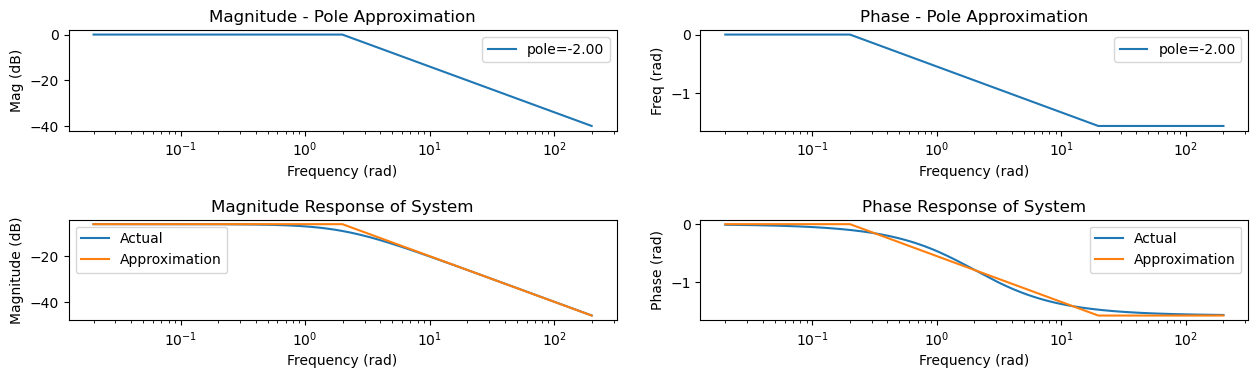

In [3]:
# Try different systems

num = np.array([1])
den = np.array([1, 2])

N = 1000
omega = eu.enel441_get_reasonable_freq_range(num, den, N)
G_jw = eu.enel441_fourier_transform(num,den,omega)
eu.enel441_approximate_bode(num,den,omega)

# Try Make a High-Pass System

1
[3.]


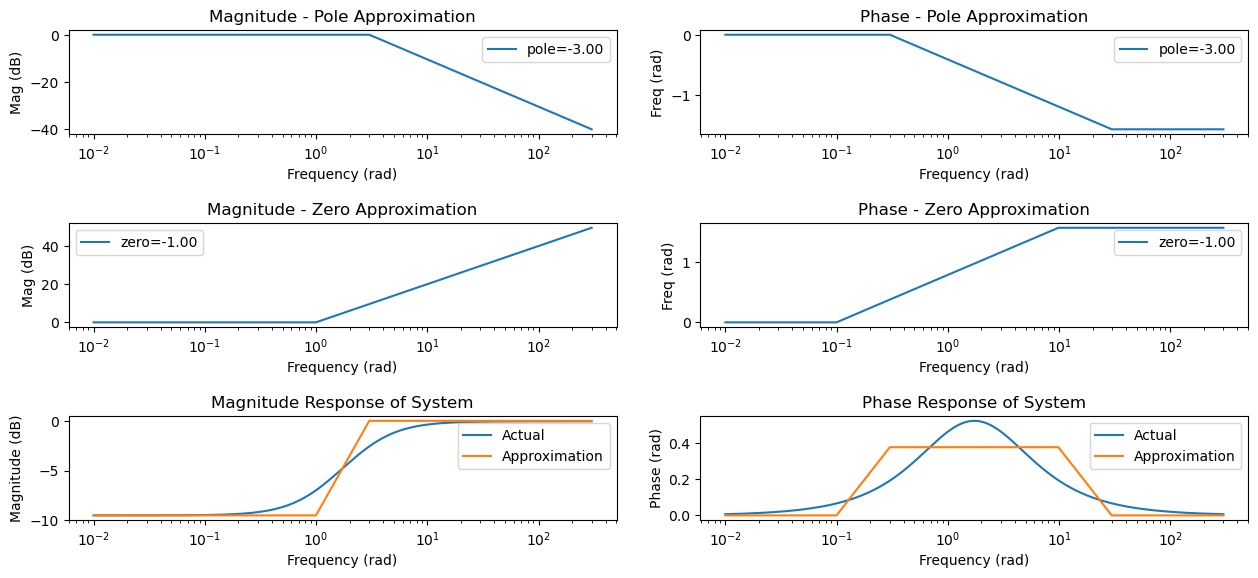

In [4]:
# Try different systems

num = np.array([1, 1])
den = np.array([1, 3])

N = 1000
omega = eu.enel441_get_reasonable_freq_range(num, den, N)
G_jw = eu.enel441_fourier_transform(num,den,omega)
eu.enel441_approximate_bode(num,den,omega)

# Try Make a Pass-Band System

[  1.  100.1  10. ]
[ 1  8 15]
[-5. -3.]
[-5. -3.]
2
[5. 3.]


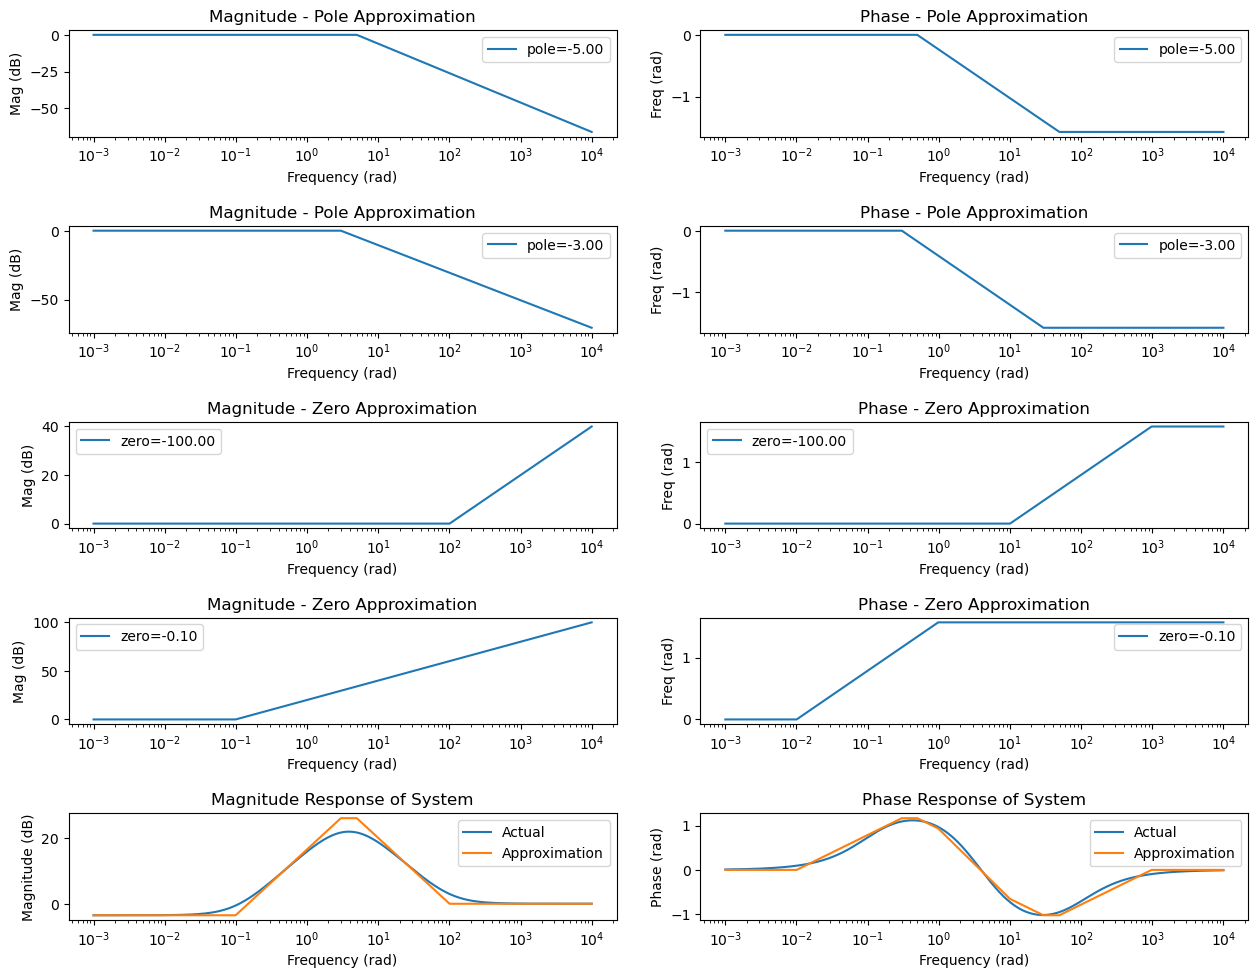

In [5]:
# Try different systems


poles = np.array([-3, -5])
zeros = np.array([-0.1, -100])
num = eu.roots_to_polynomial(zeros)
den = eu.roots_to_polynomial(poles)


print(num)
print(den)
print(np.roots(den))
print(np.roots(den))




N = 1000
omega = eu.enel441_get_reasonable_freq_range(num, den, N)
G_jw = eu.enel441_fourier_transform(num,den,omega)
eu.enel441_approximate_bode(num,den,omega)

# Try Different Second-order systems

What do you notice about the approximate version of the Bode Plot?
When is the approximation worst? 
What affects the resonant peak?

[1]
[  1.     0.2  100.01]
2
[10.00049999 10.00049999]


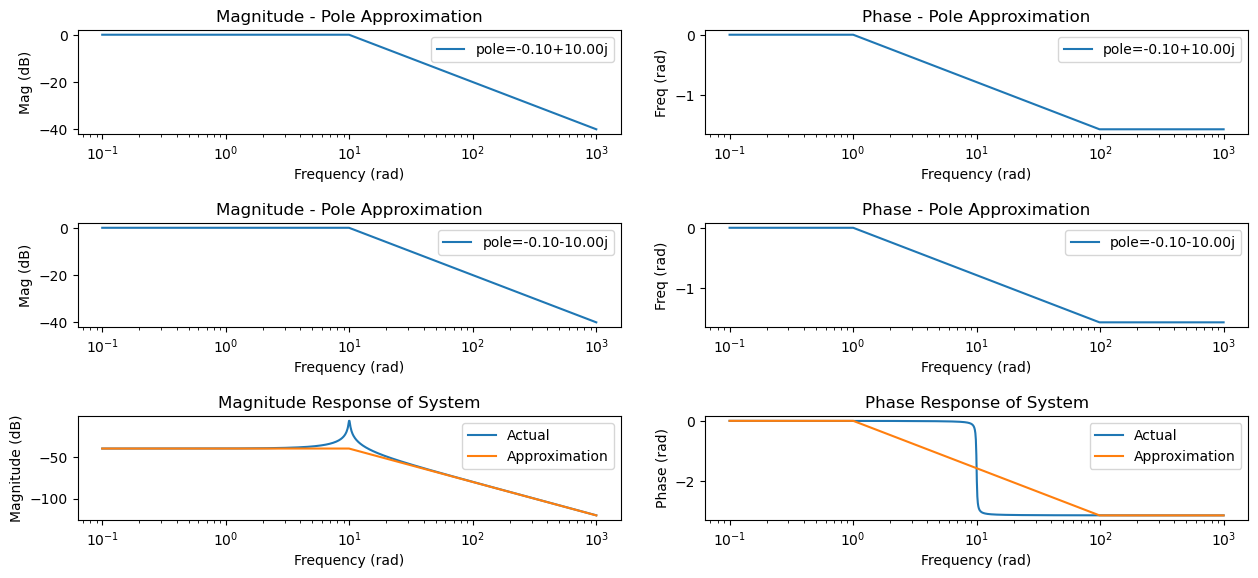

In [6]:
# Try different systems

# Complex poles/zeros:
# vary value of imaginary part of the pole. What happens to the actual vs approximate responses?
p_re = -0.1
p_im = 10
num = np.array([1])
den = eu.roots_to_polynomial([complex(p_re,p_im), complex(p_re,-p_im)])
print(num)
print(den)

N = 1000
omega = eu.enel441_get_reasonable_freq_range(num, den, N)
G_jw = eu.enel441_fourier_transform(num,den,omega)
eu.enel441_approximate_bode(num,den,omega)

# In Class Activity!

Add an annotation to the bode plot function that marks the corner frequencies on the plots with a star. What are the corner frequencies again?


[1]
[ 1. -2.  2.]


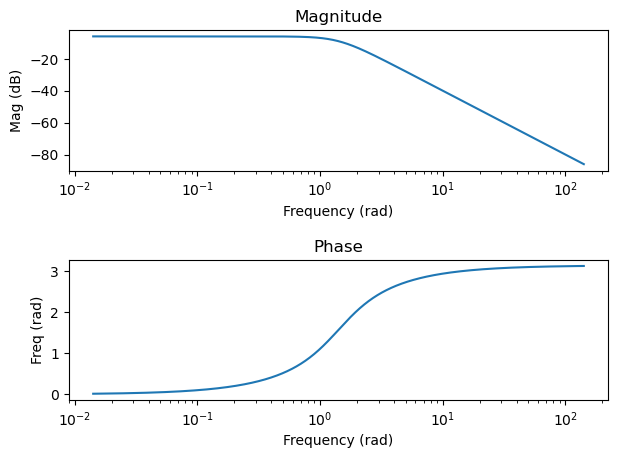

In [8]:
def enel441_annotated_bode_plot(num, den, omega):

    # Add code here to calculate the corner frequencies related to the numerator and denominator.
    # If there are no corner frequencies associated with the numerator, pass an empty numpy array: num_corner_freqs = np.array([])
    
    # Replace the following two lines with your block of code        
    den_corner_freqs = np.array([])
    num_corner_freqs = np.array([])
    
    corner_freq_indeces_poles = np.zeros(den_corner_freqs.shape[0], dtype=int)
    ii = 0
    for cf in den_corner_freqs:
        corner_freq_indeces_poles[ii] = find_nearest(omega,cf)
        ii += 1
    
    corner_freq_indeces_zeros = np.zeros(num_corner_freqs.shape[0],dtype=int)
    ii = 0
    for cf in num_corner_freqs:
        corner_freq_indeces_zeros[ii] = find_nearest(omega,cf)
        ii += 1

    G_jw = enel441_fourier_transform(num,den,omega)
    fig, ax = plt.subplots(2,1)
    mag_plot = 20*np.log10(np.abs(G_jw))
    ax[0].semilogx(omega, mag_plot) 
    ax[0].set_title('Magnitude')
    ax[0].set_xlabel('Frequency (rad)')
    ax[0].set_ylabel('Mag (dB)')
    ax[0].plot(omega[corner_freq_indeces_poles], mag_plot[corner_freq_indeces_poles], 'kx')
    ax[0].plot(omega[corner_freq_indeces_zeros], mag_plot[corner_freq_indeces_zeros], 'ko')
    
    phase_plot = np.angle(G_jw)
    ax[1].semilogx(omega, phase_plot)
    ax[1].set_title('Phase')
    ax[1].set_xlabel('Frequency (rad)')
    ax[1].set_ylabel('Freq (rad)')
    ax[1].plot(omega[corner_freq_indeces_poles], phase_plot[corner_freq_indeces_poles], 'kx')
    ax[1].plot(omega[corner_freq_indeces_zeros], phase_plot[corner_freq_indeces_zeros], 'ko')

    fig.tight_layout(pad=1.5)

#num_sys = np.array([1, 1])
#den_sys = np.array([1, 2, 2])
p_re = 1
p_im = 1
num_sys = np.array([1])
den_sys = eu.roots_to_polynomial([complex(p_re,p_im), complex(p_re,-p_im)])

print(num_sys)
print(den_sys)



N = 1000
omega = enel441_get_reasonable_freq_range(num_sys, den_sys, N)
enel441_annotated_bode_plot(num_sys, den_sys, omega)



# 2 Rotating Disks Revisited

![2 Disk Graphic Diagram](2diskGraphic.png "2 Disk Graphic Diagram")

Look at the Bode Plot of the Rotation Disk example from last lecture. Instead of choosing $\theta_2$ as the output, choose $\frac{d \theta_2}{dt}$. How does this affect the transfer function?

We had derived:
$$
\begin{align*}
\frac{\Theta_2(s)}{T_M(s)} = G(s)
\end{align*}
$$

Let $v_2(t)$ be the angular velocity of disk 2. Then:
$$
\begin{align*}
v_2(t) &= \frac{d \theta_2(t)}{dt} \\
V_2(s) &= s \Theta_2(s)
\end{align*}
$$

Now we want to find the transfer function from $T_M$ to $v_2(t)$: 
$$
\begin{align*}
\frac{\Theta_2(s)}{T_M(s)} &= G(s) \\
\frac{V_2(s)}{s T_M(s)} &= G(s) \\
\frac{V_2(s)}{T_M(s)} &= s G(s)
\end{align*}
$$
So the transfer function is:
$$
\begin{align*}
\frac{V_2(s)}{T_M(s)} = \frac{1}{ \frac{J_1J_2}{k}s^3 + \frac{J_1b + J_2b}{k}s^2 + (J_1 + J_2 + \frac{b^2}{k}) s + 2b}  
\end{align*}
$$

What do you notice in the Bode Plot?

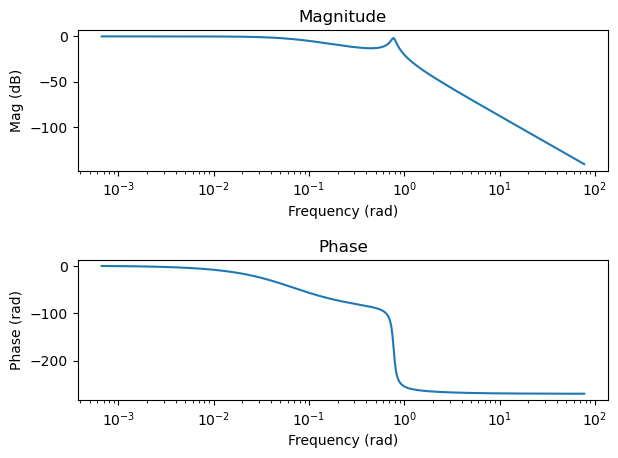

In [5]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import enel441_utilities as eu

J1 = 10
J2 = 5
k = 2
b = 0.5

num_sys = np.array([1])
den_sys = np.array([J1*J2/k, (J1+J2)*b/k, (J1+J2+b**2/k), 2*b])

N = 1000
omega = eu.enel441_get_reasonable_freq_range(num_sys,den_sys,N)
G_jw = eu.enel441_fourier_transform(num_sys,den_sys,omega)
eu.enel441_bode(G_jw,omega)


# Frequency Domain Representation 
- Emphasizes which frequencies are attenuated, and which ones are amplified. 
- This will be very useful throughout the remainder of the term.

# Summary of Part 1
Key takeaway's:
- There are many ways to represent a system (Differential Equations, State Space, Frequency Domain, Transfer Function)
- Each representation has advantages:
    - Differential Equations: we live in time domain
    - State Space: easily extended to large/complex systems
    - Frequency Domain: see difference between high-pass and low-pass behaviors
    - Transfer function: poles/zeros are very obvious, compact representation, block diagrams
- It is possible to transform from one representation to another
- The poles of a system show up in every representation in different ways!
    - Differential Equations: decay rate of the exponential function
    - Transfer function: roots of the denominator
    - Frequency Domain: corner frequencies of the Bode plot 
    - State Space: Eigen values of the $A$ matrix
- For a second order system, the poles can be directly related to characteristics of the step response of a system (Rise time, settling time, percent overshoot). For higher order systems, the relations can still hold approximately.

